In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from scipy import stats
%matplotlib inline
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import pydotplus as pdot

/Users/anupsagar/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/anupsagar/anaconda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


#### Load the dataset

In [2]:
hr_df = pd.read_csv('HR_data.csv')
hr_df.head(3)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium


In [3]:
hr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


#### Are there any null or missing values in the dataset?

In [4]:
hr_df.isnull().any().sum()

0

In [5]:
hr_df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

#### Exploratory Analysis

#### How many numbers of people leaving the company exist in the dataset?

In [6]:
hr_left_df = pd.DataFrame(hr_df.left.value_counts())
hr_left_df

,left
0,11428
1,3571


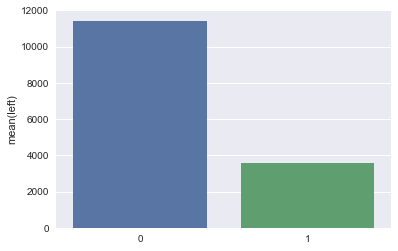

In [7]:
sn.barplot(hr_left_df.index, hr_left_df.left)

#### Summary of columns

In [8]:
hr_df.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


#### The summary statistics for 'Work_accident', 'left' and 'promotion_last_5years' does not make sense, as they are categorical variables.

#### How many people, who had work accidents, actually left the company?

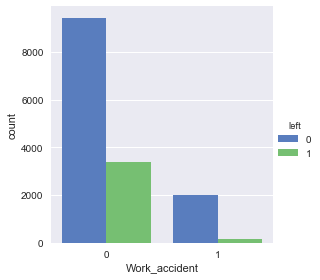

In [9]:
work_accident_count = hr_df[['Work_accident', 'left']].groupby(['Work_accident', 'left']).size().reset_index()
work_accident_count.columns = ['Work_accident', 'left', 'count']

sn.factorplot(x="Work_accident", y = 'count', hue="left", data=work_accident_count,
               size=4, kind="bar", palette="muted")

In [10]:
work_accident_count = hr_df[['Work_accident', 'left']].groupby(['Work_accident', 'left']).size()
work_accident_percent = work_accident_count.groupby(level=[0]).apply(lambda x: x / x.sum()).reset_index()

#### In terms of percentage

In [11]:
work_accident_percent.columns = ['Work_accident', 'left', 'percent']

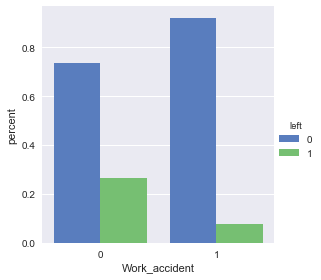

In [12]:
sn.factorplot(x="Work_accident", y = 'percent', hue="left", data=work_accident_percent,
               size=4, kind="bar", palette="muted")

#### How work accidents have impacted the statisfactin level of the empolyees?

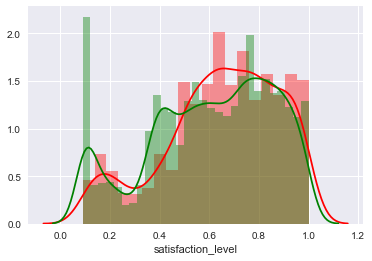

In [13]:
sn.distplot( hr_df[hr_df.Work_accident == 1]['satisfaction_level'], color = 'r')
sn.distplot( hr_df[hr_df.Work_accident == 0]['satisfaction_level'], color = 'g')

#### How satisfaction levels influence whether to stay or leave the company?

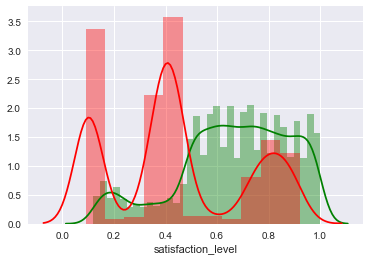

In [14]:
sn.distplot( hr_df[hr_df.left == 0]['satisfaction_level'], color = 'g')
sn.distplot( hr_df[hr_df.left == 1]['satisfaction_level'], color = 'r')

##### It can be noted, large number of people who had lower satisfaction levels, have left the company. Especially, people who have satisfaction level less than 0.5. This makes sense. But there is also a surge in at higher level of satisfaction. Need to understand and deal with these employees with a different stategy.

#### Average satisfaction levels for people who leave and stay back in the company

In [15]:
sl_left_mean = np.mean( hr_df[hr_df.left == 0]['satisfaction_level'] )
sl_left_mean

0.666809590479516

In [16]:
np.std( hr_df[hr_df.left == 0]['satisfaction_level'] )

0.21709425554771716

In [17]:
np.mean( hr_df[hr_df.left == 1]['satisfaction_level'] )

0.44009801176140917

In [18]:
np.std( hr_df[hr_df.left == 1]['satisfaction_level'] )

0.2638964784854295

#### Hypothesis Test: Does lower satisfaction levels lead to people leaving the company
#### H0 : Average satisfaction level of people leaving is same as average satisfaction of people staying
#### H1 : Average satisfaction level of people leaving is less than as average satisfaction of people staying

In [19]:
stats.ttest_ind( hr_df[hr_df.left == 1]['satisfaction_level'], hr_df[hr_df.left == 0]['satisfaction_level'])

Ttest_indResult(statistic=-51.61280155890104, pvalue=0.0)

##### The test establishes that the average satisfaction levels are different.

#### How last evaluation scores influencing whether to stay or leave the company?

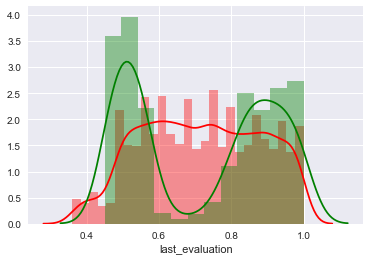

In [20]:
sn.distplot( hr_df[hr_df.left == 0]['last_evaluation'], color = 'r')
sn.distplot( hr_df[hr_df.left == 1]['last_evaluation'], color = 'g')

##### People with low evaluation and very high evaluation are leaving, where as people with average evaluation scores are staying back. That seems interesting.

#### How time spent in company influences attrition?

In [21]:
time_spend_count = hr_df[['time_spend_company', 'left']].groupby(['time_spend_company', 'left']).size()
time_spend_percent = time_spend_count.groupby(level=[0]).apply(lambda x: x / x.sum()).reset_index()
time_spend_percent.columns = ['time_spend_company', 'left', 'percent']

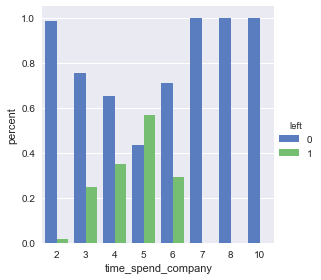

In [22]:
sn.factorplot(x="time_spend_company", y = 'percent', hue="left", data=time_spend_percent,
               size=4, kind="bar", palette="muted")

##### People who have spent 2 years are not leaving the company. But as experience grows people start leaving and highest after they spend 5 years in the company. But once they cross the golden years '7', they are not leaving.

#### Which department has maximum attrition?

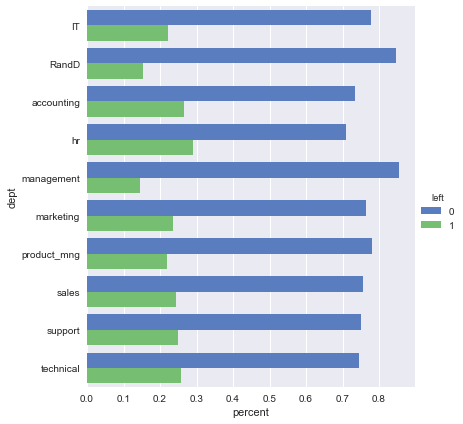

In [23]:
dept_count = hr_df[['sales', 'left']].groupby(['sales', 'left']).size()
dept_count_percent = dept_count.groupby(level=[0]).apply(lambda x: x / x.sum()).reset_index()
dept_count_percent.columns = ['dept', 'left', 'percent']
sn.factorplot(y="dept",
            x = 'percent',
            hue="left",
            data = dept_count_percent,
            size=6,
            kind="bar",
            palette="muted")

##### The percentage of people leaving the company is evenly distributed across all depts. Surprisingly, the percentage is high in HR itself. Lowest in management.

#### Effect of whether someone got promoted in last 5 year

In [24]:
pd.crosstab( hr_df.promotion_last_5years, hr_df.left )

left,0,1
promotion_last_5years,,
0,11128,3552
1,300,19


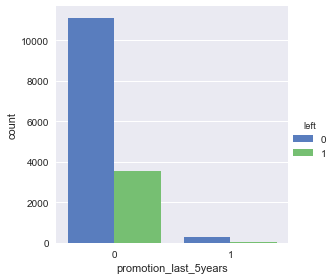

In [25]:
sn.factorplot(x="promotion_last_5years", hue = 'left', data=hr_df,
               size=4, kind="count", palette="muted")

##### Very few people who got promoted in last 5 years left the company, compared to people who are not promoted in last 5 years

#### How Salary is influencing attrition decisions?

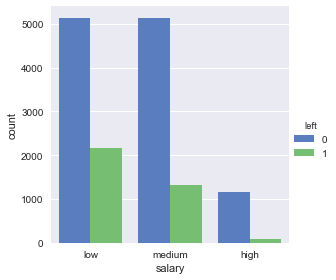

In [26]:
sn.factorplot(x="salary", hue = 'left', data=hr_df,
               size=4, kind="count", palette="muted")

#### Does higher salary lead to higher satisfaction level?

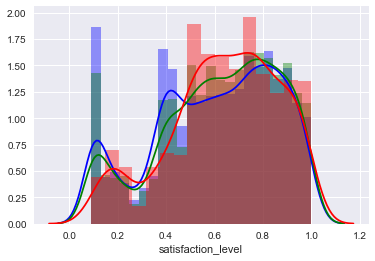

In [27]:
sn.distplot( hr_df[hr_df.salary == 'low']['satisfaction_level'], color = 'b')
sn.distplot( hr_df[hr_df.salary == 'medium']['satisfaction_level'], color = 'g')
sn.distplot( hr_df[hr_df.salary == 'high']['satisfaction_level'], color = 'r')

#### How salaries across departments are related to attrition?

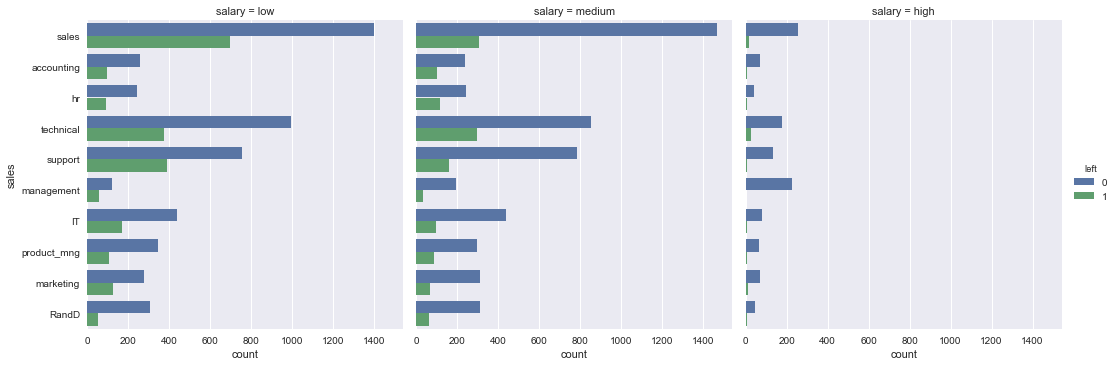

In [28]:
sn.factorplot( y = "sales",
            col="salary",
            hue = "left",
            data=hr_df,
            kind="count",
            size=5)

##### No surprises. People with lowers salary have maximum percentage of exodus, while people with higher salary the exodus is least.

#### Lets check corrleation between Variables

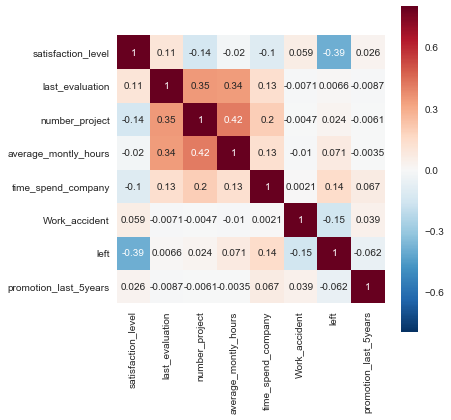

In [29]:
corrmat = hr_df.corr()
f, ax = plt.subplots(figsize=(6, 6))
sn.heatmap(corrmat, vmax=.8, square=True, annot=True)
plt.show()

#### Encoding Categorical Features

In [30]:
numerical_features = ['satisfaction_level', 'last_evaluation', 'number_project',
     'average_montly_hours', 'time_spend_company']

In [31]:
categorical_features = ['Work_accident','promotion_last_5years', 'sales', 'salary']

#### An utility function to create dummy variable

In [32]:
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

In [33]:
for c_feature in categorical_features:
  hr_df = create_dummies(hr_df, c_feature)

In [34]:
hr_df[0:5]

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,left,Work_accident_1,promotion_last_5years_1,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,salary_low,salary_medium
0,0.38,0.53,2,157,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0
1,0.80,0.86,5,262,6,1,0,0,0,0,0,0,0,0,1,0,0,0,1
2,0.11,0.88,7,272,4,1,0,0,0,0,0,0,0,0,1,0,0,0,1
3,0.72,0.87,5,223,5,1,0,0,0,0,0,0,0,0,1,0,0,1,0
4,0.37,0.52,2,159,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0


#### Splitting the dataset

In [35]:
feature_columns = hr_df.columns.difference( ['left'] )
feature_columns

Index(['Work_accident_1', 'average_montly_hours', 'last_evaluation',
       'number_project', 'promotion_last_5years_1', 'salary_low',
       'salary_medium', 'sales_RandD', 'sales_accounting', 'sales_hr',
       'sales_management', 'sales_marketing', 'sales_product_mng',
       'sales_sales', 'sales_support', 'sales_technical', 'satisfaction_level',
       'time_spend_company'],
      dtype='object')

In [36]:
train_X, test_X, train_y, test_y = train_test_split( hr_df[feature_columns],
                                                  hr_df['left'],
                                                  test_size = 0.2,
                                                  random_state = 42 )

#### Building Models

#### Logistic Regression Model

In [37]:
logreg = LogisticRegression()
logreg.fit( train_X, train_y )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [38]:
list( zip( feature_columns, logreg.coef_[0] ) )

[('Work_accident_1', -1.492662273241121),
 ('average_montly_hours', 0.0049756295542857168),
 ('last_evaluation', 0.59258560152125361),
 ('number_project', -0.30373338699890184),
 ('promotion_last_5years_1', -1.2172794666390891),
 ('salary_low', 1.8131727427552242),
 ('salary_medium', 1.3088620777422102),
 ('sales_RandD', -0.5707635224786074),
 ('sales_accounting', 0.0930031125057868),
 ('sales_hr', 0.35887723308063302),
 ('sales_management', -0.36238815703379673),
 ('sales_marketing', 0.13047437008142895),
 ('sales_product_mng', 0.023809246134627697),
 ('sales_sales', 0.075841827611528925),
 ('sales_support', 0.1349394388253958),
 ('sales_technical', 0.1954553863872413),
 ('satisfaction_level', -4.1082674603754104),
 ('time_spend_company', 0.26529857471457918)]

In [39]:
logreg.intercept_

array([-1.53003346])

# Predicting the test cases

In [40]:
hr_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': logreg.predict( test_X ) } )

In [41]:
hr_test_pred = hr_test_pred.reset_index()

#### Comparing the predictions with actual test data

In [42]:
hr_test_pred.sample( n = 10 )

,index,actual,predicted
392,11842,0,0
678,13865,0,0
1257,1684,1,1
1499,7517,0,0
275,12159,1,0
2965,12923,0,0
2032,10065,0,0
483,2684,0,0
1273,6504,0,0
2092,7019,0,0


#### Creating a confusion matrix

In [43]:
cm = metrics.confusion_matrix( hr_test_pred.actual,
                            hr_test_pred.predicted, [1,0] )
cm

array([[ 225,  481],
       [ 175, 2119]])

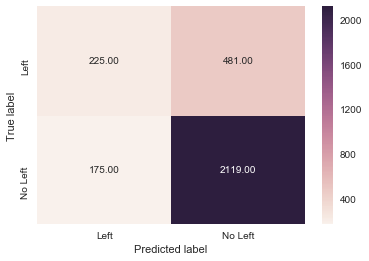

In [44]:
sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [45]:
score = metrics.accuracy_score( hr_test_pred.actual, hr_test_pred.predicted )
round( float(score), 2 )

0.78

#### Predit Probability

In [46]:
test_X[:1]

,Work_accident_1,average_montly_hours,last_evaluation,number_project,promotion_last_5years_1,salary_low,salary_medium,sales_RandD,sales_accounting,sales_hr,sales_management,sales_marketing,sales_product_mng,sales_sales,sales_support,sales_technical,satisfaction_level,time_spend_company
6723,1,226,0.96,5,0,0,1,0,0,0,0,1,0,0,0,0,0.65,2


In [47]:
logreg.predict_proba( test_X[:1] )

array([[ 0.97203474,  0.02796526]])

#### The model is predicting the probability of him leaving the company is only 0.027, which is very low.

#### How good the model is?

In [48]:
predict_proba_df = pd.DataFrame( logreg.predict_proba( test_X ) )
predict_proba_df.head()

,0,1
0,0.972035,0.027965
1,0.917792,0.082208
2,0.770442,0.229558
3,0.523038,0.476962
4,0.975843,0.024157


In [49]:
hr_test_pred = pd.concat( [hr_test_pred, predict_proba_df], axis = 1 )

In [50]:
hr_test_pred.columns = ['index', 'actual', 'predicted', 'Left_0', 'Left_1']

In [51]:
auc_score = metrics.roc_auc_score( hr_test_pred.actual, hr_test_pred.Left_1  )
round( float( auc_score ), 2 )

0.81

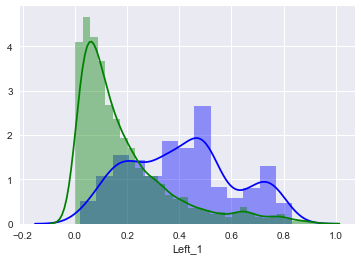

In [52]:
sn.distplot( hr_test_pred[hr_test_pred.actual == 1]["Left_1"], color = 'b' )
sn.distplot( hr_test_pred[hr_test_pred.actual == 0]["Left_1"], color = 'g' )

#### Finding the optimal cutoff probability

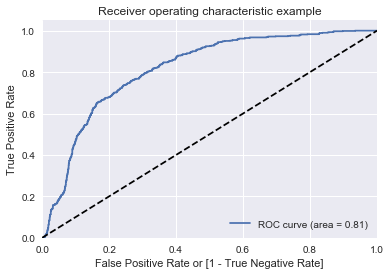

In [53]:
fpr, tpr, thresholds = metrics.roc_curve( hr_test_pred.actual,
                                     hr_test_pred.Left_1,
                                     drop_intermediate = False )

plt.figure(figsize=(6, 4))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [54]:
thresholds[0:10]

array([ 1.91905403,  0.91905403,  0.90057485,  0.88605896,  0.88001362,
        0.87933851,  0.87233301,  0.86974565,  0.86193267,  0.85880292])

In [55]:
fpr[0:10]

array([ 0.        ,  0.00087184,  0.00130776,  0.00174368,  0.0021796 ,
        0.00261552,  0.00305144,  0.00348736,  0.00392328,  0.0043592 ])

In [56]:
tpr[0:10]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [57]:
cutoff_prob = thresholds[(np.abs(tpr - 0.7)).argmin()]
round( float( cutoff_prob ), 2 )

0.28

#### Predicting with new cut-off probability

In [58]:
hr_test_pred['new_labels'] = hr_test_pred['Left_1'].map( lambda x: 1 if x >= 0.28 else 0 )

In [59]:
hr_test_pred[0:10]

,index,actual,predicted,Left_0,Left_1,new_labels
0,6723,0,0,0.972035,0.027965,0
1,6473,0,0,0.917792,0.082208,0
2,4679,0,0,0.770442,0.229558,0
3,862,1,0,0.523038,0.476962,1
4,7286,0,0,0.975843,0.024157,0
5,8127,0,0,0.722851,0.277149,0
6,3017,0,0,0.985596,0.014404,0
7,3087,0,1,0.130254,0.869746,1
8,6425,0,0,0.769714,0.230286,0
9,2250,0,1,0.398617,0.601383,1


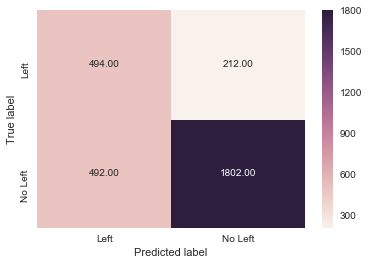

In [60]:
cm = metrics.confusion_matrix( hr_test_pred.actual,
                          hr_test_pred.new_labels, [1,0] )
sn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Building Decision Tree

In [61]:
param_grid = {'max_depth': np.arange(3, 10)}

tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 10)
tree.fit( train_X, train_y )

GridSearchCV(cv=10, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([3, 4, 5, 6, 7, 8, 9])},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [62]:
tree.best_params_

{'max_depth': 9}

In [63]:
tree.best_score_

0.9807483956996417

#### Build Final Decision Tree Model

In [64]:
clf_tree = DecisionTreeClassifier( max_depth = 9 )
clf_tree.fit( train_X, train_y, )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [65]:
tree_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': clf_tree.predict( test_X ) } )

In [66]:
tree_test_pred.sample( n = 10 )

,actual,predicted
5129,0,0
10664,0,0
1139,1,1
6742,0,0
5361,0,0
5216,0,0
10024,0,0
9604,0,0
6425,0,0
6572,0,0


In [67]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.predicted )

0.97866666666666668

#### Wow! the accuracy is about 98%.

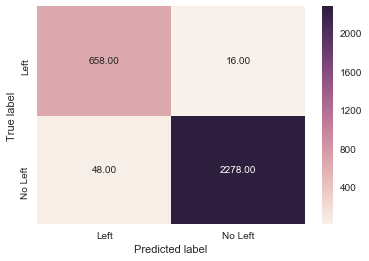

In [68]:
tree_cm = metrics.confusion_matrix( tree_test_pred.predicted,
                                 tree_test_pred.actual,
                                 [1,0] )
sn.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Generate rules from the decision tree

In [69]:
export_graphviz(clf_tree,
              out_file = "hr_tree.odt",
              feature_names = train_X.columns )

In [70]:
chd_tree_graph = pdot.graphviz.graph_from_dot_file( 'hr_tree.odt' )

In [71]:
chd_tree_graph.write_jpg( 'hr_tree.jpg' )

True

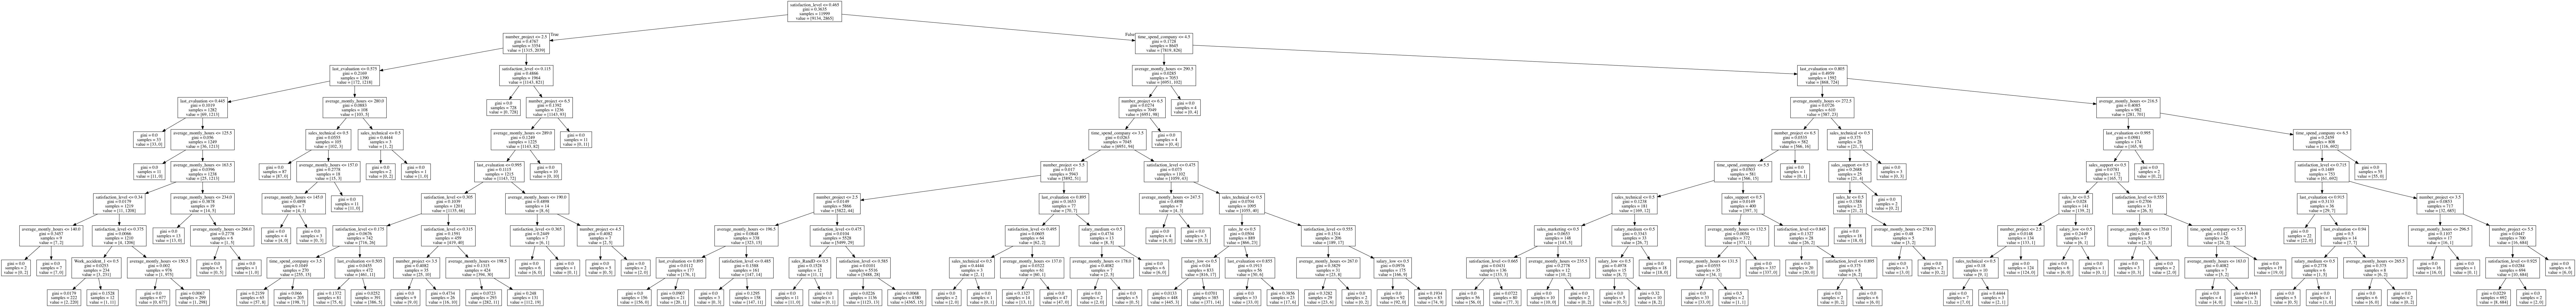

In [72]:
from IPython.display import Image
Image(filename='hr_tree.jpg')

#### Random Forest Model

In [73]:
radm_clf = RandomForestClassifier()
radm_clf.fit( train_X, train_y )

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [74]:
radm_test_pred = pd.DataFrame( { 'actual':  test_y,
                            'predicted': radm_clf.predict( test_X ) } )

In [75]:
metrics.accuracy_score( radm_test_pred.actual, radm_test_pred.predicted )

0.98633333333333328

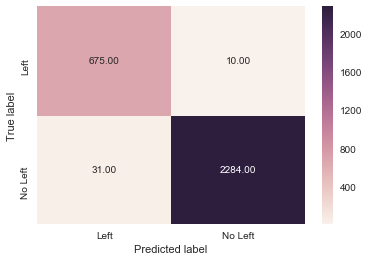

In [76]:
tree_cm = metrics.confusion_matrix( radm_test_pred.predicted,
                                 radm_test_pred.actual,
                                 [1,0] )
sn.heatmap(tree_cm, annot=True,
         fmt='.2f',
         xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label')

#### Feature Importance from Random Forest Model

In [77]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]

In [78]:
indices

array([16, 17,  3,  1,  2,  0,  5,  6, 15, 13, 14, 10, 11,  7,  8, 12,  9,
        4])

In [79]:
feature_rank = pd.DataFrame( columns = ['rank', 'feature', 'importance'] )
for f in range(train_X.shape[1]):
  feature_rank.loc[f] = [f+1,
                         train_X.columns[indices[f]],
                         radm_clf.feature_importances_[indices[f]]]

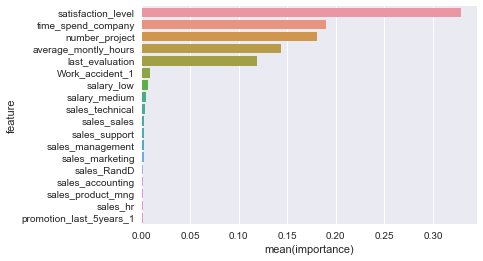

In [80]:
sn.barplot( y = 'feature', x = 'importance', data = feature_rank )

In [81]:
selected_features = ['satisfaction_level',
                     'number_project',
                     'time_spend_company',
                     'last_evaluation',
                     'average_montly_hours']

#### Building a Decision Tree with important features

In [82]:
clf_tree = DecisionTreeClassifier( max_depth = 4 )
clf_tree.fit( train_X[selected_features], train_y, )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [83]:
dtree_test_pred = pd.DataFrame( { 'actual':  test_y,
                              'predicted': clf_tree.predict( test_X[selected_features] ) } )

In [84]:
metrics.accuracy_score( dtree_test_pred.actual, 
                        dtree_test_pred.predicted )

0.96733333333333338

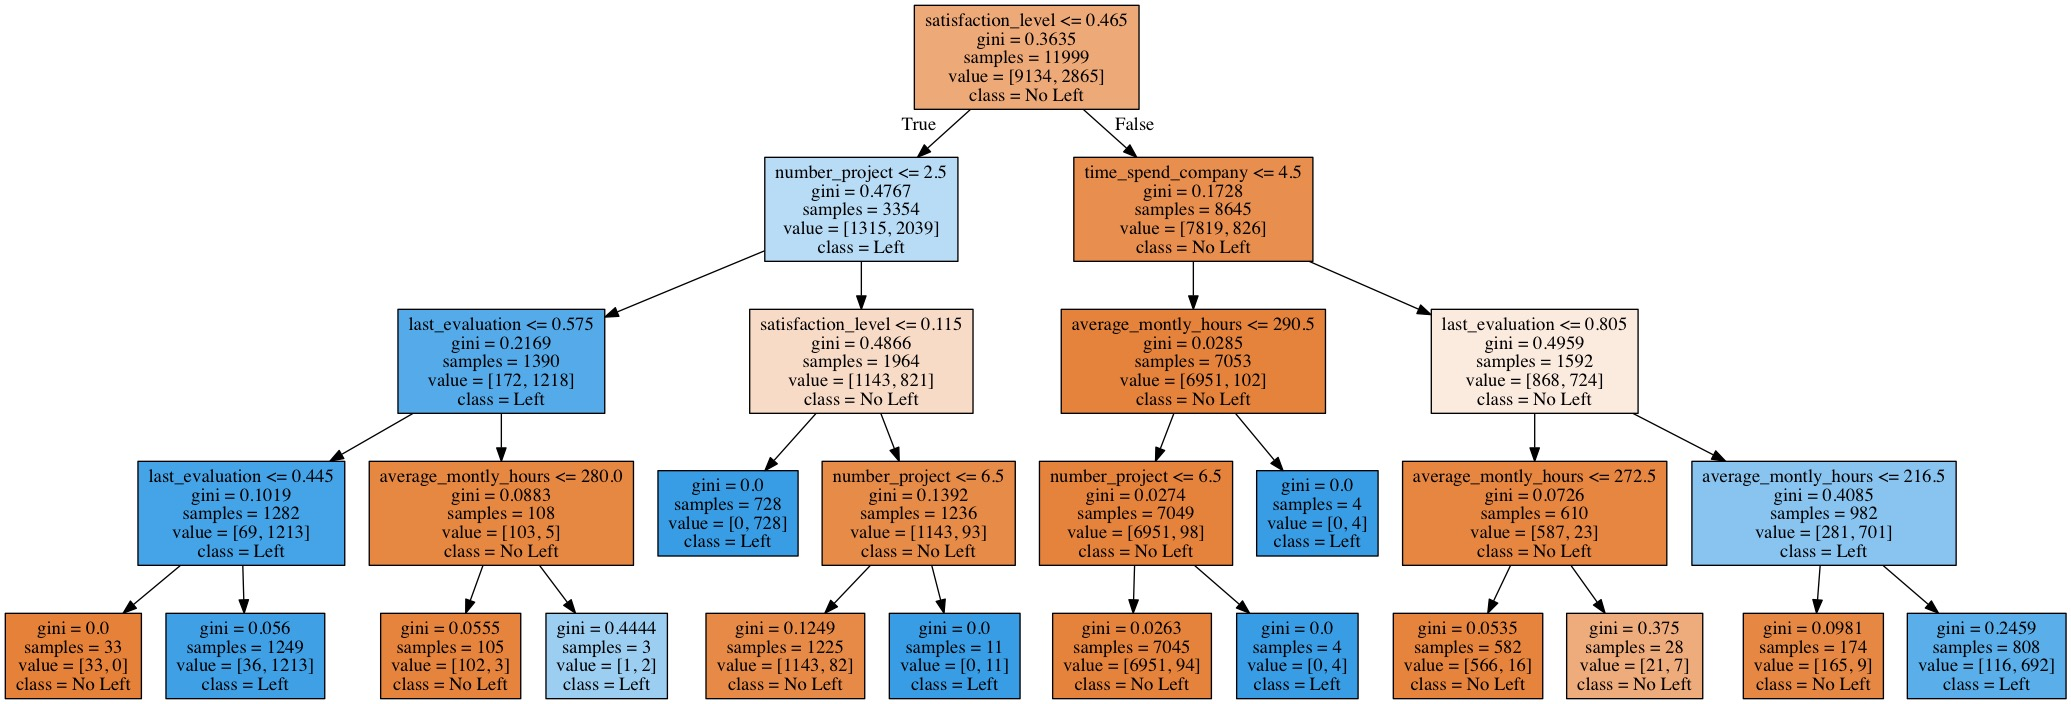

In [85]:
export_graphviz( clf_tree,
                out_file = "hr_tree_2.odt",
                class_names = ['No Left', 'Left'],
                filled = True,
                feature_names = selected_features )
chd_tree_graph = pdot.graphviz.graph_from_dot_file( 'hr_tree_2.odt' )
chd_tree_graph.write_jpg( 'hr_tree_2.jpg' )
from IPython.display import Image
Image(filename='hr_tree_2.jpg')

#### Grid Search for KNN

In [86]:
tuned_parameters = [{'n_neighbors': [5, 10, 15, 20]}]

In [87]:
clf = GridSearchCV(KNeighborsClassifier(),
                 tuned_parameters,
                 cv=5,
                 scoring='roc_auc')

clf.fit(train_X, train_y )

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_neighbors': [5, 10, 15, 20]}],
       pre_dispatch='2*n_jobs', refit=True, scoring='roc_auc', verbose=0)

In [88]:
clf.grid_scores_

[mean: 0.96985, std: 0.00354, params: {'n_neighbors': 5},
 mean: 0.97154, std: 0.00315, params: {'n_neighbors': 10},
 mean: 0.97028, std: 0.00360, params: {'n_neighbors': 15},
 mean: 0.96826, std: 0.00381, params: {'n_neighbors': 20}]

In [89]:
clf.best_params_

{'n_neighbors': 10}

In [90]:
clf.best_score_

0.9715421239344966

#### KNN Model

In [91]:
knn_clf = KNeighborsClassifier( n_neighbors = 10 )
knn_clf.fit( train_X, train_y )

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')

In [92]:
knn_test_pred = pd.DataFrame( { 'actual':  test_y,
                              'predicted': knn_clf.predict( test_X ) } )

In [93]:
metrics.roc_auc_score( knn_test_pred.actual, knn_test_pred.predicted )

0.92426974173296028

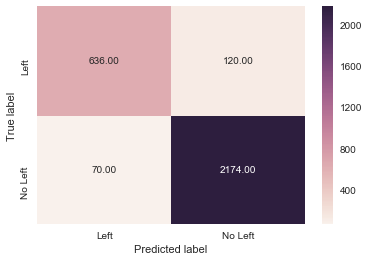

In [94]:
tree_cm = metrics.confusion_matrix( knn_test_pred.predicted,
                                    knn_test_pred.actual,
                                   [1,0] )
sn.heatmap(tree_cm, annot=True,  
           fmt='.2f', 
           xticklabels = ["Left", "No Left"] , yticklabels = ["Left", "No Left"] )

plt.ylabel('True label')
plt.xlabel('Predicted label');